In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler as MMS

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
from tgan2 import *

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
batch_size= 128
current_day = '2020-05-01'
seq_len = 24
z_dim = 5

In [ ]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, z_dim))

random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(1976)
                     .repeat())

In [4]:
g_net = load_model(f'D:\CTS_GAN\models\g_models/{current_day}tg', compile=False)
r_net = load_model(f'D:\CTS_GAN\models/r_models/{current_day}tg',compile = False)
e_net = load_model(f'D:\CTS_GAN\models\e_models/{current_day}tg',compile = False)
d_net = load_model(f'D:\CTS_GAN\models\d_models/{current_day}tg',compile = False)
s_net = load_model(f'D:\CTS_GAN\models\s_models/{current_day}tg',compile = False)

In [5]:
Z = next(random_series)

In [6]:
E_hat = g_net(Z)
H_hat = s_net(E_hat)
X_hat = r_net(H_hat)

In [7]:
DATA_DIR = 'D:\\CTS_GAN\\data'
def multi_stock_loading_first():

    data_dir = {'google': f"{DATA_DIR}/GOOG.csv", 'apple': f"{DATA_DIR}/AAPL.csv",
                'meta': f"{DATA_DIR}/META.csv", 'netflix': f"{DATA_DIR}/NFLX.csv",
                'amazon': f"{DATA_DIR}/AMZN.csv" }
    data = pd.read_csv(data_dir['meta'])
    data['Date'] = pd.to_datetime(data['Date'])

    for st, st_dir in data_dir.items():
        tmp = pd.read_csv(st_dir)
        tmp = tmp.rename(columns={'Adj Close': st})
        tmp['Date'] = pd.to_datetime(tmp['Date'])
        data = pd.merge(data, tmp[['Date', st]], on='Date', how='inner')
    #Only keep Adj Close column
    data.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], inplace=True)

    return data

window_size = 2000
SEED = 3407 
set_random_seed(SEED)
data = multi_stock_loading_first()
start_day = 0

while start_day < len(data) - window_size:

    current_day = data.iloc[start_day + window_size]['Date'].strftime('%Y-%m-%d')
    print(current_day)
    tmp = data.iloc[start_day: start_day + window_size]
    data_v = tmp.drop(columns='Date').values
    break

2020-05-01


In [8]:
scaler = MMS()
scaled_data = scaler.fit_transform(data_v).astype(np.float32)

data = []
for i in range(len(data_v) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(1976))
real_series_iter = iter(real_series.repeat())

In [9]:
X=data

In [10]:
sample_size = 300
idx = np.random.permutation(len(X))[:sample_size]
real_sample = np.asarray(X)[idx]
synthetic_sample = np.asarray(X_hat)[idx]

In [11]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)
print(real_sample_2d.shape)
print(synthetic_sample_2d.shape)

(1500, 24)
(1500, 24)


In [12]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

In [13]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.000s...
[t-SNE] Computed neighbors for 3000 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.096689
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.550453
[t-SNE] KL divergence after 1000 iterations: 0.307291


In [14]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*5:, 'Data'] = 'Synthetic'

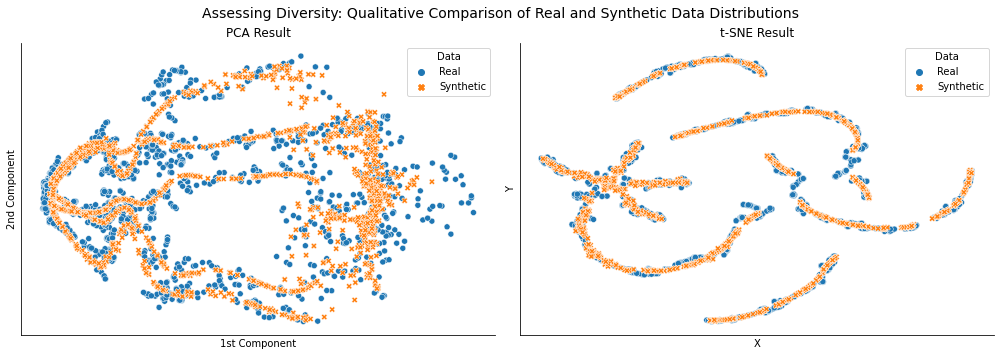

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Quantitative

In [16]:
n_data = len(data)
idx = np.arange(n_data)
n_train = int(0.8 * n_data)
train_idx = idx[:n_train]
test_idx = idx[n_train:]
train_data = np.vstack((np.array(X)[train_idx], 
                        np.array(X_hat)[train_idx]))
test_data = np.vstack((np.array(X)[test_idx], 
                       np.array(X_hat)[test_idx]))
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

# classifier

In [17]:
import keras
keras.utils.set_random_seed(100)

In [18]:
ts_classifier = Sequential([GRU(24, input_shape=(24, 5), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [19]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [20]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 24)                2232      
                                                                 
 OUT (Dense)                 (None, 1)                 25        
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=200,
                           batch_size=64,
                           verbose=0)

In [22]:
ts_classifier.evaluate(x=test_data, y=test_labels)

25/25 [==============================] - 0s 5ms/step - loss: 1.9736 - AUC: 0.5613 - accuracy: 0.4874


[1.9735651016235352, 0.561269223690033, 0.4873737394809723]

In [23]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          200 non-null    float64
 1   AUC           200 non-null    float64
 2   accuracy      200 non-null    float64
 3   val_loss      200 non-null    float64
 4   val_AUC       200 non-null    float64
 5   val_accuracy  200 non-null    float64
dtypes: float64(6)
memory usage: 9.5 KB


In [24]:
from matplotlib.ticker import FuncFormatter

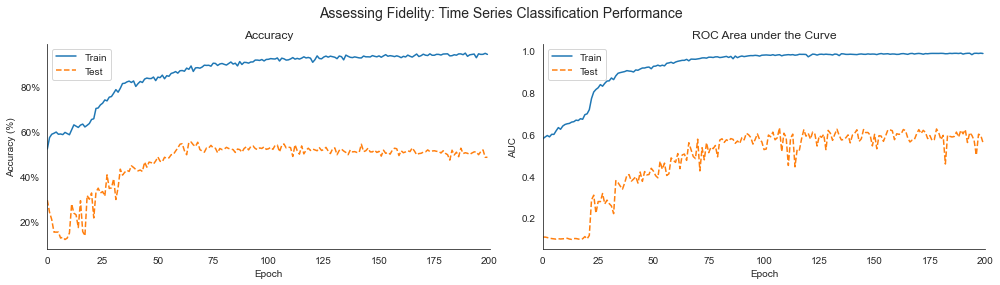

In [25]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 200))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 200))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# Assessing usefull

In [53]:
real_data = np.array(X)
synthetic_data = np.array(X_hat)

In [54]:
real_data.shape, synthetic_data.shape

((1976, 24, 5), (1976, 24, 5))

In [55]:
real_train_data = real_data[train_idx, 1:23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, 1:23, :]
real_test_label = real_data[test_idx, -1, :]

In [56]:
synthetic_train = synthetic_data[:, 1:23, :]
synthetic_label = synthetic_data[:, -1, :]

In [57]:
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len-2, 5)),
                        Dense(5)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [58]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=150,
                                     batch_size=128,
                                     verbose=0)

In [59]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=150,
                                batch_size=128,
                                verbose=0)

In [60]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

In [73]:
synthetic_result

,Train,Test
0,0.276295,0.463931
1,0.190647,0.327570
2,0.137612,0.232875
3,0.097017,0.150816
4,0.068875,0.096662
...,...,...
145,0.001792,0.016966
146,0.001868,0.016831
147,0.001902,0.016962
148,0.001871,0.016870


In [61]:
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

In [74]:
real_result

,Train,Test
0,0.134579,0.290509
1,0.089068,0.214455
2,0.064257,0.181822
3,0.054786,0.158724
4,0.046409,0.137274
...,...,...
145,0.005124,0.017444
146,0.005170,0.017143
147,0.005126,0.017611
148,0.005057,0.017533


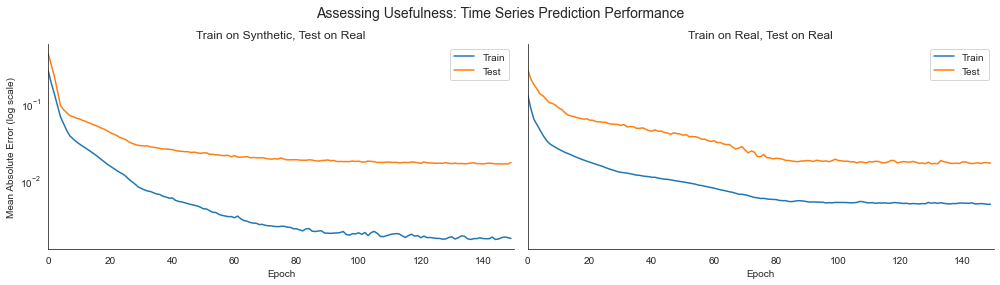

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 150))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 150))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# Loss

In [63]:
e_loss = pd.read_csv('D:\\TC_GAN\\loss/step_e_loss_t0.csv')

In [64]:
e_loss.columns = ['step', 'loss']
e_loss['step'] = e_loss.index*10

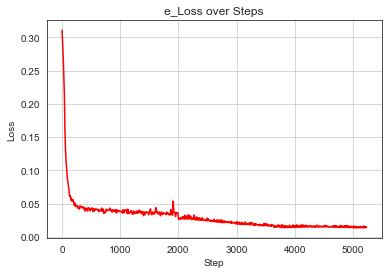

In [75]:
plt.plot(e_loss['step'], e_loss['loss'], color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('e_Loss over Steps')
plt.grid(True)
plt.show()

In [66]:
s_loss = pd.read_csv('D:\\TC_GAN\\loss/step_g_loss_s.csv')

In [67]:
s_loss.columns = ['step', 'loss']
s_loss['step'] = s_loss.index*10

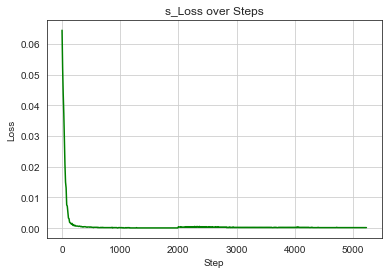

In [79]:
plt.plot(s_loss['step'], s_loss['loss'], color='green')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('s_Loss over Steps')
plt.grid(True)
plt.show()

In [69]:
g_loss = pd.read_csv('D:\\TC_GAN\\loss/g_loss_u.csv')
d_loss = pd.read_csv('D:\\TC_GAN\\loss/d_loss.csv')

In [70]:
d_loss.columns = ['step', 'loss']
d_loss['step'] = d_loss.index*10
g_loss.columns = ['step', 'loss']
g_loss['step'] = g_loss.index*10

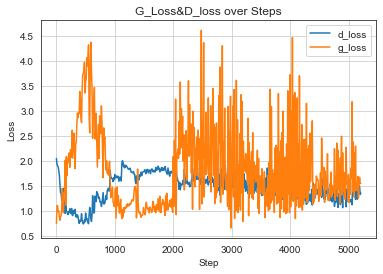

In [71]:
plt.plot(d_loss['step'], d_loss['loss'], label='d_loss')
plt.plot(g_loss['step'], g_loss['loss'], label='g_loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('G_Loss&D_loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

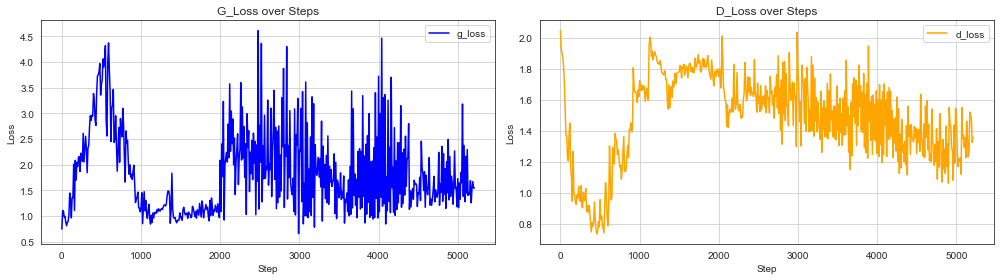

In [78]:
plt.figure(figsize=(14, 4))
# Plotting G_loss
plt.subplot(1, 2, 1)
plt.plot(g_loss['step'], g_loss['loss'], label='g_loss', color='blue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('G_Loss over Steps')
plt.legend()
plt.grid(True)

# Plotting D_loss
plt.subplot(1, 2, 2)
plt.plot(d_loss['step'], d_loss['loss'], label='d_loss', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('D_Loss over Steps')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()